In [264]:
import pandas as pd
import numpy as np
import re, hashlib, os
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier

import lightgbm as lgb

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [265]:
#loading data
df = pd.read_csv('data_anonymized_with_user_ids.csv')
df.head()

,FirstName,FullName,user_id,town,countPoints,Item,Date,Price,Format
0,Павел,Павел,USER_923730,АСТАНА,335,94140036 Серьги (Ag 925),2024-09-25,28 000,Оффлайн
1,Павел,Павел,USER_923730,АСТАНА,335,94020535 Серьги (Ag 925),2024-09-25,11 199,Оффлайн
2,Артем,Артем,USER_215040,АСТАНА,655,94026740 Серьги (Ag 925),2024-11-14,21 860,Оффлайн
3,Дмитрий,Дмитрий,USER_313086,АСТАНА,378,10-0179_ам_175 Кольцо (Ag 925),2024-06-21,4 511,Оффлайн
4,Дмитрий,Дмитрий,USER_313086,АСТАНА,378,11-0075_АМ Серьги (Ag 925),2024-06-21,7 088,Оффлайн


In [266]:
#cleaning
df = df.drop(columns=["FirstName", "FullName", "town", "Format", "countPoints", ])
df.head()
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df["Price"] = (
    df["Price"]
    .astype(str)
    .str.replace(r"\s+", "", regex=True)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

In [267]:
print(df['Date'].min(), df['Date'].max())

2022-04-23 00:00:00 2025-10-09 00:00:00


In [268]:
min_purchases = 3
min_lifetime_days = 30

mask = (
    (X["num_purchases"] >= min_purchases) &
    (X["customer_lifetime"] >= min_lifetime_days)
)

X_clean = X[mask]
y_clean = y[mask]

print(f"Осталось {len(X_clean)} клиентов из {len(X)} ({len(X_clean)/len(X):.1%})")
print("Доля покупателей в таргете:", y_clean.mean())


Осталось 75 клиентов из 6856 (1.1%)
Доля покупателей в таргете: 0.28


In [269]:
def make_features(df, cutoff_date):
    df = df[df["Date"] <= cutoff_date].copy()

    agg = (
        df.groupby("user_id")
        .agg(
            total_spent=("Price", "sum"),
            avg_spent=("Price", "mean"),
            num_purchases=("Price", "count"),
            unique_items=("Item", "nunique"),
            last_purchase=("Date", "max"),
            first_purchase=("Date", "min"),
        )
        .reset_index()
    )

    for days in [30, 90]:
        recent = df[df["Date"] > cutoff_date - pd.Timedelta(days=days)]
        temp = (
            recent.groupby("user_id")
            .agg(
                **{
                    f"spent_last_{days}d": ("Price", "sum"),
                    f"purchases_last_{days}d": ("Price", "count"),
                }
            )
            .reset_index()
        )
        agg = agg.merge(temp, on="user_id", how="left").fillna(0)

    agg["days_since_last_purchase"] = (cutoff_date - agg["last_purchase"]).dt.days
    agg["customer_lifetime"] = (agg["last_purchase"] - agg["first_purchase"]).dt.days

    agg["spend_trend"] = agg["spent_last_30d"] / (agg["spent_last_90d"] + 1)
    agg["freq_trend"] = agg["purchases_last_30d"] / (agg["purchases_last_90d"] + 1)
    agg["avg_ticket"] = agg["total_spent"] / (agg["num_purchases"] + 1)

    agg["recency_score"] = np.exp(-agg["days_since_last_purchase"] / 90)
    agg["frequency_score"] = np.log1p(agg["num_purchases"])
    agg["monetary_score"] = np.log1p(agg["total_spent"])
    agg["rfm_score"] = agg["recency_score"] + agg["frequency_score"] + agg["monetary_score"]

    agg["engagement_ratio"] = agg["spent_last_90d"] / (agg["total_spent"] + 1)
    agg["activity_ratio"] = agg["purchases_last_90d"] / (agg["num_purchases"] + 1)

    agg["avg_purchase_interval"] = agg["customer_lifetime"] / np.maximum(agg["num_purchases"] - 1, 1)
    agg["recent_spent_ratio"] = agg["spent_last_90d"] / (agg["total_spent"] + 1)

    return agg


In [270]:
epoch_windows = [
    ('2025-01-01', '2025-04-01', '2025-07-01'),
    ('2025-02-01', '2025-05-01', '2025-08-01'),
    ('2025-03-01', '2025-06-01', '2025-09-01'),
    ('2025-04-01', '2025-07-01', '2025-10-01'),
]


In [271]:
all_features = []

for start, cutoff_train, cutoff_target in epoch_windows:
    cutoff_train = pd.Timestamp(cutoff_train)
    cutoff_target = pd.Timestamp(cutoff_target)
    epoch_df = df[df["Date"] >= pd.Timestamp(start)].copy()

    feats = make_features(epoch_df, cutoff_train)
    target_users = epoch_df[
        (epoch_df["Date"] > cutoff_train) & (epoch_df["Date"] <= cutoff_target)
    ]["user_id"].unique()

    feats["target"] = feats["user_id"].isin(target_users).astype(int)
    all_features.append(feats)

train_full = pd.concat(all_features, ignore_index=True).drop_duplicates("user_id", keep="last")

X = train_full.drop(columns=["user_id", "target", "first_purchase", "last_purchase"])
y = train_full["target"]

print("Размер данных:", X.shape, "| Положительных меток:", y.sum(), f"({y.mean():.2%})")

Размер данных: (6856, 21) | Положительных меток: 535 (7.80%)


In [272]:
min_purchases = 3
min_lifetime_days = 30

mask = (
    (X["num_purchases"] >= min_purchases) &
    (X["customer_lifetime"] >= min_lifetime_days)
)

X_clean = X[mask]
y_clean = y[mask]

print(f"Осталось {len(X_clean)} клиентов из {len(X)} ({len(X_clean)/len(X):.1%})")
print("Доля покупателей в таргете:", y_clean.mean())

Осталось 75 клиентов из 6856 (1.1%)
Доля покупателей в таргете: 0.28


In [273]:
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.25, stratify=y_clean, random_state=42
)

model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    num_leaves=64,
    min_data_in_leaf=20,
    random_state=42,
    scale_pos_weight=(len(y_train) - y_train.sum()) / max(y_train.sum(), 1)
)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, y_pred)
print("ROC-AUC", roc)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 16, number of negative: 40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 56, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285714 -> initscore=-0.916291
[LightGBM] [Info] Start training from score -0.916291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

<Figure size 1000x600 with 0 Axes>

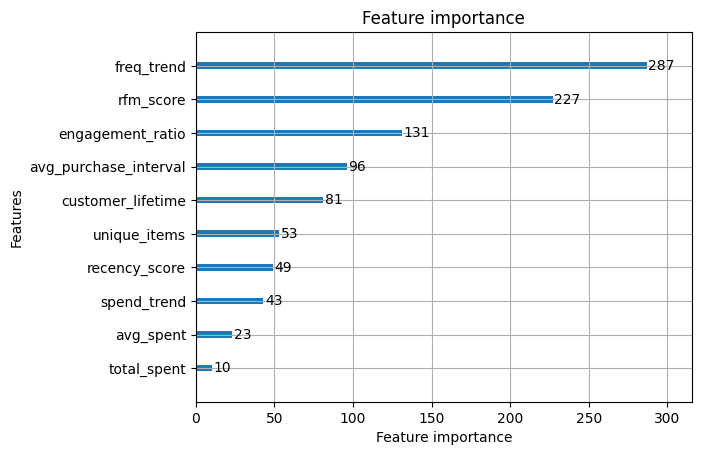

In [278]:
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15)
plt.show()

In [275]:
X_all = X_clean.copy()
user_ids = train_full.loc[X_clean.index, "user_id"].values

preds = model.predict_proba(X_all)[:, 1]

pred_df = pd.DataFrame({
    "user_id": user_ids,
    "predicted_proba": preds
}).sort_values("predicted_proba", ascending=False)

print("\nТоп-10 клиентов по вероятности будущей покупки:")
print(pred_df.head(10))

pred_df.to_csv("predicted_buyers.csv", index=False)
print("\nРезультаты сохранены в predicted_buyers.csv")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

🔮 Топ-10 клиентов по вероятности будущей покупки:
        user_id  predicted_proba
5   USER_158617         0.854944
46  USER_652814         0.812082
31  USER_490535         0.792840
64  USER_881973         0.746980
22  USER_358610         0.739436
54  USER_748884         0.716449
67  USER_909146         0.696657
72  USER_950585         0.677573
17  USER_325812         0.675035
70  USER_927703         0.663164

📁 Результаты сохранены в predicted_buyers.csv


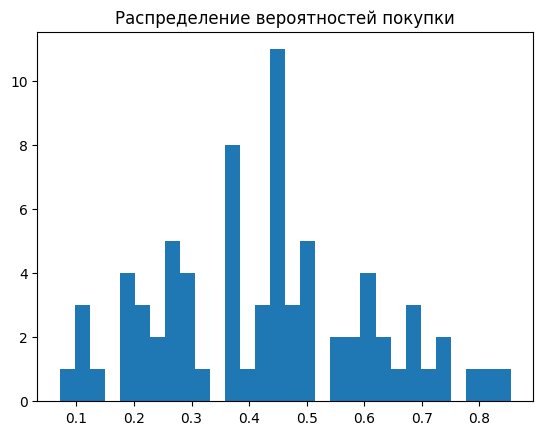

In [276]:
plt.hist(pred_df["predicted_proba"], bins=30)
plt.title("Распределение вероятностей покупки")
plt.show()


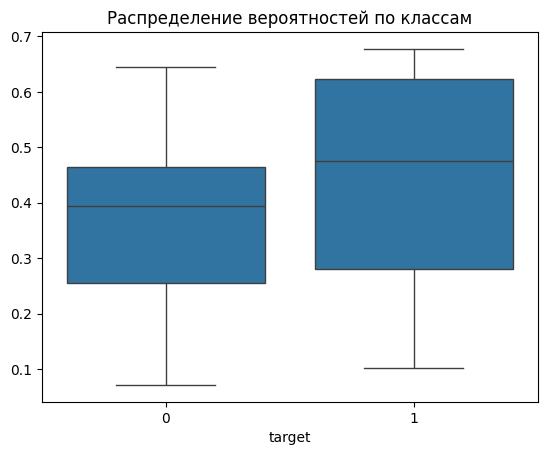

In [277]:
sns.boxplot(x=y_test, y=y_pred)
plt.title("Распределение вероятностей по классам")
plt.show()